## Standardized test cases

For benchmarking, we need a standardized set of case studies, ranging form simple to very large. This helps us to test and track the performance of improvements of bw_timex with the same set of test cases.


### 0) set up variables & functions

In [1]:
import numpy as np
import bw2data as bd

from bw_temporalis import TemporalDistribution
from datetime import datetime

from cProfile import Profile
from pstats import SortKey, Stats

import time
from bw_timex import TimexLCA


In [2]:
# Define the old and new project names
old_project_name = 'Reforrestation_Aforrestation'
new_project_name = 'timex_benchmarking'

# Restore the old project
if new_project_name not in bd.projects:
    import bw2io as bi
    import shutil
    bi.backup.restore_project_directory(fp= '/Users/ajakobs/Documents/Solene_Reforrestation_Aforrestation/brightway2-project-Reforrestation_Aforrestation-backup02-June-2025-05-23PM.tar.gz',
                                    overwrite_existing=True)


    # Set the current project to the old project
    bd.projects.set_current(old_project_name)

    # Get the project directory
    old_project_dir = bd.projects.dir

    # Create a new project
    bd.projects.set_current(new_project_name)

    # Get the new project directory
    new_project_dir = bd.projects.dir

    # Copy the old project directory to the new project directory
    shutil.copytree(old_project_dir, new_project_dir, dirs_exist_ok=True)

    print(f"Project loaded and copied to {new_project_name}.")
else:
    bd.projects.set_current(new_project_name)


In [3]:
list(bd.databases)

['ecoinvent-3.11-biosphere',
 'ecoinvent-3.11-cutoff',
 'ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30',
 'ei_cutoff_3.11_image_SSP2-M_2030 2025-05-30',
 'ei_cutoff_3.11_image_SSP2-M_2040 2025-05-30',
 'ei_cutoff_3.11_image_SSP2-M_2050 2025-05-30',
 'test_2tiers_3processes',
 'test_1tiers_1processes']

In [4]:
# Remove all test systems from the project
def clear_test_systems():
    to_delete = []
    for db in bd.databases:  # deleting all test_systems
        if "test" in db:
            to_delete.append(db)
    print(to_delete)

    for db in to_delete:
        del bd.databases[db]

    print(bd.databases)

clear_test_systems()

['test_2tiers_3processes', 'test_1tiers_1processes']
Databases dictionary with 6 object(s):
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-cutoff
	ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30
	ei_cutoff_3.11_image_SSP2-M_2030 2025-05-30
	ei_cutoff_3.11_image_SSP2-M_2040 2025-05-30
	ei_cutoff_3.11_image_SSP2-M_2050 2025-05-30


In [5]:
base_background_db = bd.Database("ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30")

In [6]:
list_random_acts = []
for i in range(0, 100):
    act = base_background_db.random()
    list_random_acts.append((act["code"]))

In [7]:
fixed_random_acts = list_random_acts

In [8]:
def create_standardized_test_system(
    db_name,
    number_tiers,
    number_processes_per_tier,
    td_timesteps,
    td_dtype,
    fixed_random_acts,
    number_background_exchanges_per_process,
    base_background_db_name,
    loop=False,
):
    """
    Create a foreground database with a standardized structure for testing purposes. It contains number_tiers supply chain levels, with each containing
    number_processes_per_tier processes. Each process consumes from all processes in the tier below. At the last tier, each process consumes a certain numebr of background process
    Each process has a temporal distribution with td_timesteps steps, e.g. 3, in td_dtype resolution, e.g. years, starting at a unit of time later than the consuming process
    The last tier consumes a process from the background system in 2020, selecting a process from a predefined list of random processes, with the same temporal distribution as above.
    If loop = True, a loop is included: the last process in last tier consumes from the last process in first tier, no TDs at this node.
    No additional TDs at biosphere flows.

    Parameters:
    db_name: str, name of the database
    number_tiers: int, number of tiers in the supply chain
    number_processes_per_tier: int, number of processes per tier
    td_timesteps: int, number of timesteps in the temporal distribution
    td_dtype: str, dtype of the temporal distribution, e.g. "timedelta64[Y]" or "timedelta64[M]"
    fixed_random_acts: a list of 100 background activities codes that has been pre-generated
    number_background_exchanges_per_process: int, number of background exchanges per process in the last tier
    base_background_db_name: str, name of the background database to use for the last tier processes, e.g. "ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30"
    loop: bool, whether to include a loop in the foreground system

    returns: None


    """

    # create a new database
    if db_name in bd.databases:
        del bd.databases[db_name]
        print(f"Database {db_name} already exists, overwriting.")
    foreground = bd.Database(db_name)
    foreground.register()

    background_db = bd.Database(
        base_background_db_name
    )  # background database for 2020 in timex project

    # save FU node
    FU_node = foreground.new_node(code="FU", name="functional unit", unit="unit")
    FU_node.save()
    FU_node.new_edge(input=FU_node, amount=1, unit="unit", type="production").save()

    # create nodes
    for tier in range(1, number_tiers + 1):
        for process in range(1, number_processes_per_tier + 1):
            process_name = f"tier{tier}_act{process}"
            process_code = f"t{tier}_a{process}"
            process_node = foreground.new_node(
                code=process_code, name=process_name, unit="unit"
            )
            process_node.save()
            process_node.new_edge(
                input=process_node, amount=1, unit="unit", type="production"
            ).save()

    # relink nodes
    for tier in range(1, number_tiers + 1):
        for process in range(1, number_processes_per_tier + 1):
            process_name = f"tier{tier}_act{process}"
            process_code = f"t{tier}_a{process}"
            process_node = foreground.get(process_code)
            if tier == 1:  # tier 1 = FU
                consuming_node = FU_node
                new_edge = consuming_node.new_edge(
                    input=process_node, amount=1, unit="unit", type="technosphere"
                )
                new_edge.save()
            else:  # lower tiers: all nodes at the tier above consume from all nodes at the tier below, with a temporal distribution specified by the inputs
                for process in range(1, number_processes_per_tier + 1):
                    consuming_node = foreground.get(f"t{tier-1}_a{process}")
                    new_edge = consuming_node.new_edge(
                        input=process_node, amount=1, unit="unit", type="technosphere"
                    )
                    temporal_distribution = TemporalDistribution(
                        date=np.array(np.arange(1, td_timesteps + 1), dtype=td_dtype),
                        amount=np.full(td_timesteps, 1 / td_timesteps),
                    )  # linear distribution between 1 and td_timesteps in years
                    new_edge["temporal_distribution"] = temporal_distribution
                    new_edge.save()

    # add background process to nodes on last tier
    count_background_act = 0  # counting upward in list of random acts
    total_background_count = 0
    for process in range(1, number_processes_per_tier + 1):
        last_foreground_node = foreground.get(f"t{number_tiers}_a{process}")

        for _ in range(1, number_background_exchanges_per_process + 1):
            background_process = background_db.get(
                code=fixed_random_acts[count_background_act]
            )
            count_background_act += 1

            new_edge = last_foreground_node.new_edge(
                input=background_process, amount=4, type="technosphere"
            )
            temporal_distribution = TemporalDistribution(
                date=np.array(np.arange(1, td_timesteps + 1), dtype=td_dtype),
                amount=np.full(td_timesteps, 1 / td_timesteps),
            )  # linear distribution between 1 and td_timesteps in years
            new_edge["temporal_distribution"] = temporal_distribution
            new_edge.save()

            if (
                count_background_act == 99
            ):  # if all 100 background processes have been used, start again
                total_background_count += count_background_act
                count_background_act = 0

    if loop:
        # add loop to foreground: last process in last tier consumes from last process in first tier, no TDs
        loop_consumer = foreground.get(f"t{number_tiers}_a{number_processes_per_tier}")
        loop_producer = foreground.get(f"t{1}_a{number_processes_per_tier}")
        new_edge = loop_consumer.new_edge(
            input=loop_producer, amount=0.3, type="technosphere"
        )
        new_edge.save()

    count_exc = 0
    for act in foreground:
        for exc in act.technosphere():
            count_exc += 1

    total_background_count += (
        count_background_act  # number of background processes used in total
    )

    print(
        f"Database {db_name} created with {len(foreground)} processes and {count_exc} exchanges. There are {total_background_count} different background processes used."
    )
    return len(foreground), count_exc, total_background_count

### 1) small system

In [9]:
def _database_dates(db_name):
    database_dates = {
    "ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30": datetime.strptime("2020", "%Y"),
    "ei_cutoff_3.11_image_SSP2-M_2030 2025-05-30": datetime.strptime("2030", "%Y"),
    "ei_cutoff_3.11_image_SSP2-M_2040 2025-05-30": datetime.strptime("2040", "%Y"),
    "ei_cutoff_3.11_image_SSP2-M_2050 2025-05-30": datetime.strptime("2050", "%Y"),
    db_name: "dynamic",
    }
    return database_dates

In [10]:
# set method
method = ('ecoinvent-3.11', 'IPCC 2021 (incl. biogenic CO2)', 'climate change: total (incl. biogenic CO2)', 'global warming potential (GWP100)')

In [33]:
# Clear any existing test systems in the project
clear_test_systems()

n_processes = np.array([1,2,3,5,10,15,20,25,30])
n_tiers = np.array([1,2])
time_steps = 3
N_repeats = 3  # number of repeats for each test to get averages

time_initialize = []
time_build_timeline = []
time_lci = []
time_lcia = []
time_total = []

# Create foreground databases with different numbers of processes and tiers
test_db_names = []
n_foreground = []
n_exchanges = []
n_background = []
nr_processes = []
nr_tiers = []

for n_tier in n_tiers[:]:
    for n_process in n_processes[:]:
        # repeat to get averages
        for repeat in range(N_repeats):
            print(f"Repeat {repeat + 1}/{N_repeats} for {n_tier} tiers and {n_process} processes...")
            nr_processes.append(n_process)
            nr_tiers.append(n_tier)
            # Create a unique database name based on the number of tiers and processes
            db_name = f"test_{n_tier}tiers_{n_process}processes"
            database_dates = _database_dates(db_name)
            test_db_names.append(db_name)
            # print(f"Processing database {db_name} with {n_tier} tiers and {n_process} processes per tier...")
            # Check if the database already exists
            if db_name not in bd.databases:
                # Create the standardized test system
                # print(f"Creating database {db_name}...")
                db_name = f"test_{n_tier}tiers_{n_process}processes"
                n_fg, n_exch, n_bg = create_standardized_test_system(db_name=db_name,
                                                number_tiers=n_tier,
                                                number_processes_per_tier=n_process,
                                                td_timesteps=time_steps,
                                                td_dtype="timedelta64[Y]",
                                                fixed_random_acts=fixed_random_acts,
                                                number_background_exchanges_per_process=2,
                                                base_background_db_name="ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30",
                                                loop=False)
                n_foreground.append(n_fg)
                n_exchanges.append(n_exch)
                n_background.append(n_bg)
            
            # Process each database
            print(f"benchmarking database {db_name}...")
            # set funcitonal unit
            FU_node = bd.Database(db_name).get("FU")
            #initialize the TimexLCA object
            t0 = time.time()
            tlca = TimexLCA(demand={FU_node: 1},
            method=method,
            database_dates=database_dates,
            )
            t1 = time.time()
            time_initialize.append(t1 - t0)
            # build the timeline
            t2 = time.time()
            tlca.build_timeline()
            t3 = time.time()
            time_build_timeline.append(t3 - t2)
            # run the LCI
            t4 = time.time()
            tlca.lci()
            t5 = time.time()
            time_lci.append(t5 - t4)
            # run the LCIA
            t6 = time.time()
            tlca.static_lcia()
            t7 = time.time()
            time_lcia.append(t7 - t6)
            time_total.append(t7 - t0)
            # print(f"{time.ctime()}: Database {db_name} processed in {t7 - t0:.2f} seconds.")
            # print("deleting test db from project...")
            del bd.databases[db_name]

[]
Databases dictionary with 6 object(s):
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-cutoff
	ei_cutoff_3.11_image_SSP2-M_2020 2025-05-30
	ei_cutoff_3.11_image_SSP2-M_2030 2025-05-30
	ei_cutoff_3.11_image_SSP2-M_2040 2025-05-30
	ei_cutoff_3.11_image_SSP2-M_2050 2025-05-30
Repeat 1/3 for 1 tiers and 1 processes...
Database test_1tiers_1processes created with 2 processes and 3 exchanges. There are 2 different background processes used.
benchmarking database test_1tiers_1processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:45:09.083 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 3


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 1 tiers and 1 processes...
Database test_1tiers_1processes created with 2 processes and 3 exchanges. There are 2 different background processes used.
benchmarking database test_1tiers_1processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:45:26.918 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 3


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 1 tiers and 1 processes...
Database test_1tiers_1processes created with 2 processes and 3 exchanges. There are 2 different background processes used.
benchmarking database test_1tiers_1processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:45:45.404 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 3


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 1 tiers and 2 processes...
Database test_1tiers_2processes created with 3 processes and 6 exchanges. There are 4 different background processes used.
benchmarking database test_1tiers_2processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:46:03.448 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 6


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 1 tiers and 2 processes...
Database test_1tiers_2processes created with 3 processes and 6 exchanges. There are 4 different background processes used.
benchmarking database test_1tiers_2processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:46:25.013 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 6


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 1 tiers and 2 processes...
Database test_1tiers_2processes created with 3 processes and 6 exchanges. There are 4 different background processes used.
benchmarking database test_1tiers_2processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:46:46.914 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 6


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 1 tiers and 3 processes...
Database test_1tiers_3processes created with 4 processes and 9 exchanges. There are 6 different background processes used.
benchmarking database test_1tiers_3processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:47:09.487 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 9


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 1 tiers and 3 processes...
Database test_1tiers_3processes created with 4 processes and 9 exchanges. There are 6 different background processes used.
benchmarking database test_1tiers_3processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:47:34.847 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 9


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 1 tiers and 3 processes...
Database test_1tiers_3processes created with 4 processes and 9 exchanges. There are 6 different background processes used.
benchmarking database test_1tiers_3processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:48:02.765 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 9


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 1 tiers and 5 processes...
Database test_1tiers_5processes created with 6 processes and 15 exchanges. There are 10 different background processes used.
benchmarking database test_1tiers_5processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:48:30.597 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 13


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 1 tiers and 5 processes...
Database test_1tiers_5processes created with 6 processes and 15 exchanges. There are 10 different background processes used.
benchmarking database test_1tiers_5processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:49:03.486 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 13


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 1 tiers and 5 processes...
Database test_1tiers_5processes created with 6 processes and 15 exchanges. There are 10 different background processes used.
benchmarking database test_1tiers_5processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:49:37.832 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 13


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 1 tiers and 10 processes...
Database test_1tiers_10processes created with 11 processes and 30 exchanges. There are 20 different background processes used.
benchmarking database test_1tiers_10processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:50:13.950 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 25


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 1 tiers and 10 processes...
Database test_1tiers_10processes created with 11 processes and 30 exchanges. There are 20 different background processes used.
benchmarking database test_1tiers_10processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:51:06.407 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 25


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 1 tiers and 10 processes...
Database test_1tiers_10processes created with 11 processes and 30 exchanges. There are 20 different background processes used.
benchmarking database test_1tiers_10processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:51:57.314 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 25


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 1 tiers and 15 processes...
Database test_1tiers_15processes created with 16 processes and 45 exchanges. There are 30 different background processes used.
benchmarking database test_1tiers_15processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:52:48.133 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 33


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 1 tiers and 15 processes...
Database test_1tiers_15processes created with 16 processes and 45 exchanges. There are 30 different background processes used.
benchmarking database test_1tiers_15processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:53:54.921 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 33


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 1 tiers and 15 processes...
Database test_1tiers_15processes created with 16 processes and 45 exchanges. There are 30 different background processes used.
benchmarking database test_1tiers_15processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:55:01.323 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 33


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 1 tiers and 20 processes...
Database test_1tiers_20processes created with 21 processes and 60 exchanges. There are 40 different background processes used.
benchmarking database test_1tiers_20processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:56:10.628 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 44


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 1 tiers and 20 processes...
Database test_1tiers_20processes created with 21 processes and 60 exchanges. There are 40 different background processes used.
benchmarking database test_1tiers_20processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:57:37.850 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 44


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 1 tiers and 20 processes...
Database test_1tiers_20processes created with 21 processes and 60 exchanges. There are 40 different background processes used.
benchmarking database test_1tiers_20processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 10:59:06.203 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 44


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 1 tiers and 25 processes...
Database test_1tiers_25processes created with 26 processes and 75 exchanges. There are 50 different background processes used.
benchmarking database test_1tiers_25processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:00:35.665 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 54


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 1 tiers and 25 processes...
Database test_1tiers_25processes created with 26 processes and 75 exchanges. There are 50 different background processes used.
benchmarking database test_1tiers_25processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:02:20.836 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 54


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 1 tiers and 25 processes...
Database test_1tiers_25processes created with 26 processes and 75 exchanges. There are 50 different background processes used.
benchmarking database test_1tiers_25processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:04:03.800 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 54


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 1 tiers and 30 processes...
Database test_1tiers_30processes created with 31 processes and 90 exchanges. There are 60 different background processes used.
benchmarking database test_1tiers_30processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:05:52.591 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 61


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 1 tiers and 30 processes...
Database test_1tiers_30processes created with 31 processes and 90 exchanges. There are 60 different background processes used.
benchmarking database test_1tiers_30processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:07:50.294 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 61


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 1 tiers and 30 processes...
Database test_1tiers_30processes created with 31 processes and 90 exchanges. There are 60 different background processes used.
benchmarking database test_1tiers_30processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:09:52.538 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 61


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 2 tiers and 1 processes...
Database test_2tiers_1processes created with 3 processes and 4 exchanges. There are 2 different background processes used.
benchmarking database test_2tiers_1processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:11:49.917 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 4


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 2 tiers and 1 processes...
Database test_2tiers_1processes created with 3 processes and 4 exchanges. There are 2 different background processes used.
benchmarking database test_2tiers_1processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:12:09.729 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 4


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 2 tiers and 1 processes...
Database test_2tiers_1processes created with 3 processes and 4 exchanges. There are 2 different background processes used.
benchmarking database test_2tiers_1processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:12:30.753 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 4


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 2 tiers and 2 processes...
Database test_2tiers_2processes created with 5 processes and 10 exchanges. There are 4 different background processes used.
benchmarking database test_2tiers_2processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:12:50.570 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 14


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 2 tiers and 2 processes...
Database test_2tiers_2processes created with 5 processes and 10 exchanges. There are 4 different background processes used.
benchmarking database test_2tiers_2processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:13:17.930 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 14


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 2 tiers and 2 processes...
Database test_2tiers_2processes created with 5 processes and 10 exchanges. There are 4 different background processes used.
benchmarking database test_2tiers_2processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:13:44.168 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 14


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 2 tiers and 3 processes...
Database test_2tiers_3processes created with 7 processes and 18 exchanges. There are 6 different background processes used.
benchmarking database test_2tiers_3processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:14:11.703 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 30


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 2 tiers and 3 processes...
Database test_2tiers_3processes created with 7 processes and 18 exchanges. There are 6 different background processes used.
benchmarking database test_2tiers_3processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:14:46.365 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 30


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 2 tiers and 3 processes...
Database test_2tiers_3processes created with 7 processes and 18 exchanges. There are 6 different background processes used.
benchmarking database test_2tiers_3processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:15:20.087 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 30


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 2 tiers and 5 processes...
Database test_2tiers_5processes created with 11 processes and 40 exchanges. There are 10 different background processes used.
benchmarking database test_2tiers_5processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:15:54.994 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 55


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 2 tiers and 5 processes...
Database test_2tiers_5processes created with 11 processes and 40 exchanges. There are 10 different background processes used.
benchmarking database test_2tiers_5processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:16:39.636 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 55


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 2 tiers and 5 processes...
Database test_2tiers_5processes created with 11 processes and 40 exchanges. There are 10 different background processes used.
benchmarking database test_2tiers_5processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:17:23.866 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 55


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 2 tiers and 10 processes...
Database test_2tiers_10processes created with 21 processes and 130 exchanges. There are 20 different background processes used.
benchmarking database test_2tiers_10processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:18:08.772 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 160


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 2 tiers and 10 processes...
Database test_2tiers_10processes created with 21 processes and 130 exchanges. There are 20 different background processes used.
benchmarking database test_2tiers_10processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:19:28.106 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 160


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 2 tiers and 10 processes...
Database test_2tiers_10processes created with 21 processes and 130 exchanges. There are 20 different background processes used.
benchmarking database test_2tiers_10processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:20:49.125 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 160


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 2 tiers and 15 processes...
Database test_2tiers_15processes created with 31 processes and 270 exchanges. There are 30 different background processes used.
benchmarking database test_2tiers_15processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:22:07.129 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 240


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 2 tiers and 15 processes...
Database test_2tiers_15processes created with 31 processes and 270 exchanges. There are 30 different background processes used.
benchmarking database test_2tiers_15processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:23:47.997 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 240


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 2 tiers and 15 processes...
Database test_2tiers_15processes created with 31 processes and 270 exchanges. There are 30 different background processes used.
benchmarking database test_2tiers_15processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:25:30.070 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 240


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 2 tiers and 20 processes...
Database test_2tiers_20processes created with 41 processes and 460 exchanges. There are 40 different background processes used.
benchmarking database test_2tiers_20processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:27:13.800 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 400


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 2 tiers and 20 processes...
Database test_2tiers_20processes created with 41 processes and 460 exchanges. There are 40 different background processes used.
benchmarking database test_2tiers_20processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:29:36.527 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 400


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 2 tiers and 20 processes...
Database test_2tiers_20processes created with 41 processes and 460 exchanges. There are 40 different background processes used.
benchmarking database test_2tiers_20processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:31:57.728 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 400


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 2 tiers and 25 processes...
Database test_2tiers_25processes created with 51 processes and 700 exchanges. There are 50 different background processes used.
benchmarking database test_2tiers_25processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:34:20.038 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 600


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 2 tiers and 25 processes...
Database test_2tiers_25processes created with 51 processes and 700 exchanges. There are 50 different background processes used.
benchmarking database test_2tiers_25processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:37:24.291 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 600


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 2 tiers and 25 processes...
Database test_2tiers_25processes created with 51 processes and 700 exchanges. There are 50 different background processes used.
benchmarking database test_2tiers_25processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:40:26.084 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 600


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 1/3 for 2 tiers and 30 processes...
Database test_2tiers_30processes created with 61 processes and 990 exchanges. There are 60 different background processes used.
benchmarking database test_2tiers_30processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:43:28.555 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 780


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 2/3 for 2 tiers and 30 processes...
Database test_2tiers_30processes created with 61 processes and 990 exchanges. There are 60 different background processes used.
benchmarking database test_2tiers_30processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:47:10.906 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 780


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


Repeat 3/3 for 2 tiers and 30 processes...
Database test_2tiers_30processes created with 61 processes and 990 exchanges. There are 60 different background processes used.
benchmarking database test_2tiers_30processes...


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.30e+12)
  warnings.warn(msg, UmfpackWarning)
2025-06-18 11:50:51.824 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal
Calculation count: 780


/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.49e+12)
  warnings.warn(msg, UmfpackWarning)


In [ ]:
len_processes = len(n_processes)
len_tiers = len(n_tiers)
# Reshape the results
time_initialize = np.asarray(time_initialize).reshape(len_tiers, len_processes, N_repeats)
time_build_timeline = np.asarray(time_build_timeline).reshape(len_tiers, len_processes, N_repeats)
time_lci = np.asarray(time_lci).reshape(len_tiers, len_processes, N_repeats)
time_lcia = np.asarray(time_lcia).reshape(len_tiers, len_processes, N_repeats)
time_total = np.asarray(time_total).reshape(len_tiers, len_processes, N_repeats)
nr_processes = np.asarray(nr_processes).reshape(len_tiers, len_processes, N_repeats)
nr_tiers = np.asarray(nr_tiers).reshape(len_tiers, len_processes, N_repeats)
n_foreground = np.asarray(n_foreground).reshape(len_tiers, len_processes, N_repeats)
n_exchanges = np.asarray(n_exchanges).reshape(len_tiers, len_processes, N_repeats)
n_background = np.asarray(n_background).reshape(len_tiers, len_processes, N_repeats)

In [ ]:
# option to save results

import os

# Ensure the save_path directory exists
save_path = "~/timex_benchmarking_results" # change to your name

os.makedirs(save_path, exist_ok=True)

# List of arrays to save
arrays_to_save = [
    'time_initialize', 'time_build_timeline', 'time_lci', 'time_lcia', 'time_total',
    'nr_processes', 'nr_tiers', 'n_foreground', 'n_exchanges', 'n_background'
]

for arr_name in arrays_to_save:
    arr = globals()[arr_name]
    np.save(os.path.join(save_path, f"{arr_name}.npy"), arr)

In [35]:
for i,tier in enumerate(n_tiers[:]):
    for j,process in enumerate(n_processes[:]):
        db_name = f"test_{tier}tiers_{process}processes"
        print(f"Database {db_name} total time: {time_total[i,j,:].mean():.2f} +/- {time_total[i,j,:].std():.2f} seconds.")
        print(f"Time to initialize: {time_initialize[i,j,:].mean():.2f} +/- {time_initialize[i,j,:].std():.2f} seconds.")
        print(f"Time to build timeline: {time_build_timeline[i,j,:].mean():.2f} +/- {time_build_timeline[i,j,:].std():.2f} seconds.")
        print(f"Time to run LCI: {time_lci[i,j,:].mean():.2f} +/- {time_lci[i,j,:].std():.2f} seconds.")
        print(f"Time to run LCIA: {time_lcia[i,j,:].mean():.2f} +/- {time_lcia[i,j,:].std():.2f} seconds.")

Database test_1tiers_1processes total time: 18.09 +/- 0.31 seconds.
Time to initialize: 4.88 +/- 0.33 seconds.
Time to build timeline: 7.65 +/- 0.20 seconds.
Time to run LCI: 5.56 +/- 0.04 seconds.
Time to run LCIA: 0.00 +/- 0.00 seconds.
Database test_1tiers_2processes total time: 21.95 +/- 0.33 seconds.
Time to initialize: 5.03 +/- 0.04 seconds.
Time to build timeline: 10.74 +/- 0.41 seconds.
Time to run LCI: 6.18 +/- 0.07 seconds.
Time to run LCIA: 0.00 +/- 0.00 seconds.
Database test_1tiers_3processes total time: 26.92 +/- 1.22 seconds.
Time to initialize: 5.30 +/- 0.41 seconds.
Time to build timeline: 14.61 +/- 0.79 seconds.
Time to run LCI: 7.00 +/- 0.25 seconds.
Time to run LCIA: 0.00 +/- 0.00 seconds.
Database test_1tiers_5processes total time: 34.11 +/- 1.02 seconds.
Time to initialize: 5.10 +/- 0.05 seconds.
Time to build timeline: 20.96 +/- 0.48 seconds.
Time to run LCI: 8.05 +/- 0.65 seconds.
Time to run LCIA: 0.00 +/- 0.00 seconds.
Database test_1tiers_10processes total ti

# Plotting the results

In [ ]:
# import plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

## Plot the time for the different TLCA steps vs the nr of processes (per tier) 

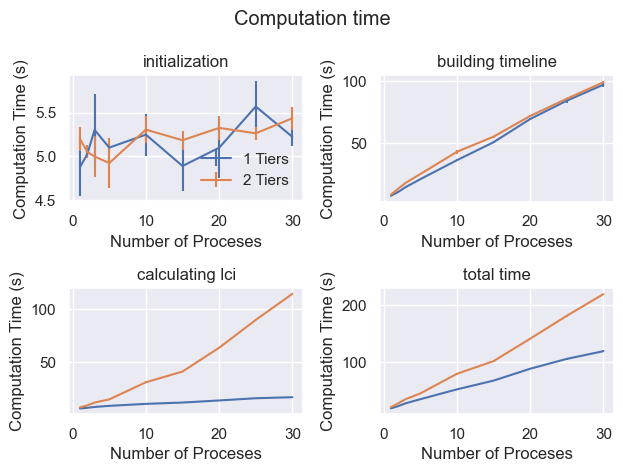

In [36]:
timing_cat_names = ['initialization','building timeline', 'calculating lci', 'total time']
timing_cats = [time_initialize,time_build_timeline, time_lci, time_total]
fig = plt.figure()

for i,(cat_name, timing_cat) in enumerate(zip(timing_cat_names, timing_cats)):
   
    ax = fig.add_subplot(2,2,i+1)
    ax.set_xlabel('Number of Proceses')
    ax.set_ylabel('Computation Time (s)')
    ax.set_title(cat_name)
    for j,n_tier in enumerate(n_tiers[:]):
        ax.errorbar(nr_processes[j,:,:].mean(axis=1), timing_cat[j,:,:].mean(axis=1), yerr=timing_cat[j,:,:].std(axis=1),  label=f'{n_tier} Tiers')
    
    if i == 0:
        ax.legend(frameon=False)   

fig.suptitle('Computation time')
plt.tight_layout()




## Plot the Total time against the various metrics (nr of processes, exchanges, etc)

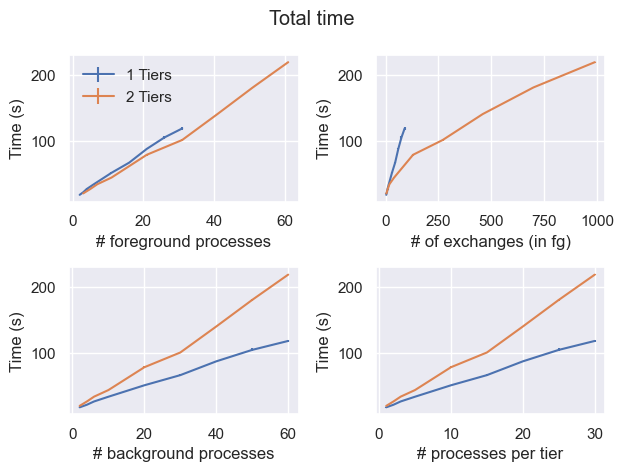

In [44]:
timing_cat_names = ['# foreground processes','# of exchanges (in fg)', '# background processes', '# processes per tier']
timing_cats = [n_foreground, n_exchanges, n_background, nr_processes]

fig = plt.figure()

for i,(cat_name,timing_cat) in enumerate(zip(timing_cat_names, timing_cats)):
   
    ax = fig.add_subplot(2,2,i+1)
    ax.set_xlabel(cat_name)
    ax.set_ylabel('Time (s)')
    # ax.set_title(cat_name)
    for j,n_tier in enumerate(n_tiers[:2]):
        ax.errorbar(timing_cat[j,:,:].mean(axis=1), time_total[j,:,:].mean(axis=1), yerr=time_total[j,:,:].std(axis=1), label=f'{n_tier} Tiers')
    
    if i == 0:
        ax.legend(frameon=False)   

fig.suptitle('Total time')
plt.tight_layout()




In [45]:
## Plot the time to build the timeline against the various metrics (nr of processes, exchanges, etc)

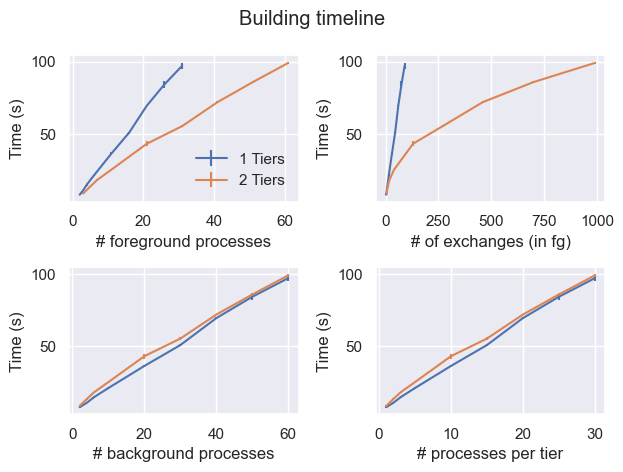

In [46]:


fig = plt.figure()

for i,(cat_name,timing_cat) in enumerate(zip(timing_cat_names, timing_cats)):
   
    ax = fig.add_subplot(2,2,i+1)
    ax.set_xlabel(cat_name)
    ax.set_ylabel('Time (s)')
    # ax.set_title(cat_name)
    for j,n_tier in enumerate(n_tiers[:2]):
        ax.errorbar(timing_cat[j,:,:].mean(axis=1), time_build_timeline[j,:,:].mean(axis=1), yerr=time_build_timeline[j,:,:].std(axis=1), label=f'{n_tier} Tiers')
    
    if i == 0:
        ax.legend(frameon=False)   

fig.suptitle('Building timeline')
plt.tight_layout()




## Plot the LCI calculation time against the various metrics (nr of processes, exchanges, etc)

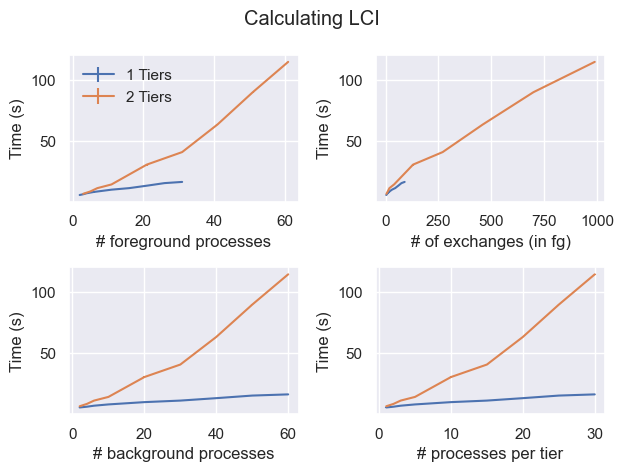

In [47]:

fig = plt.figure()

for i,(cat_name,timing_cat) in enumerate(zip(timing_cat_names, timing_cats)):
   
    ax = fig.add_subplot(2,2,i+1)
    ax.set_xlabel(cat_name)
    ax.set_ylabel('Time (s)')
    # ax.set_title(cat_name)
    for j,n_tier in enumerate(n_tiers[:2]):
        ax.errorbar(timing_cat[j,:,:].mean(axis=1), time_lci[j,:,:].mean(axis=1), yerr=time_lci[j,:,:].std(axis=1), label=f'{n_tier} Tiers')
    
    if i == 0:
        ax.legend(frameon=False)   

fig.suptitle('Calculating LCI')
plt.tight_layout()


